# Median House Value as a Logistic Regression Problem (Batch update)
#### Tensorflow 2

Google Colab runtime type has been set to GPU.

## 1. Import libraries

In [ ]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


## 2. Load data

In [ ]:
ATT_FILE = "/gdrive/My Drive/Colab Notebooks/datasets/Housing/MedianHouseValue/MedianHouseValuePreparedCleanAttributes.csv"
LABEL_FILE = "/gdrive/My Drive/Colab Notebooks/datasets/Housing/MedianHouseValue/MedianHouseValueOneHotEncodedClasses.csv"

TRAIN_RATE=0.8

attributes = pd.read_csv(ATT_FILE)
label = pd.read_csv(LABEL_FILE)

n_instances = attributes.shape[0]
n_train = int(n_instances*TRAIN_RATE)
n_dev = int((n_instances-n_train)/2)
#n_final_test = n_instances-n_train-n_dev

x_train = attributes.values[:n_train]
t_train = label.values[:n_train]

x_dev = attributes.values[n_train:n_train+n_dev]
t_dev = label.values[n_train:n_train+n_dev]

print ("x_train:",x_train.shape)
print ("t_train:",t_train.shape)

print ("x_dev:",x_dev.shape)
print ("t_dev:",t_dev.shape)

# We cannot employ the final test examples yet, since this is not the final neural approach.  

x_train: (16342, 9)
t_train: (16342, 3)
x_dev: (2043, 9)
t_dev: (2043, 3)


## 3. Initialize variables

In [ ]:
INPUTS = x_train.shape[1]
OUTPUTS = t_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(x_train.shape[0]/1))
NUM_DEV_EXAMPLES = int (round (x_dev.shape[0]/1))

Some data is displayed to test correctness:

In [ ]:
x_train[:5]

array([[ 0.21713147, -0.69394261,  0.41176471, -0.93926446, -0.88733706,
        -0.90924634, -0.89278079, -0.77585137, -1.        ],
       [-0.69322709,  0.17747078, -0.29411765, -0.91795107, -0.88671633,
        -0.95448303, -0.88949186, -0.59159184,  1.        ],
       [ 0.44820717, -0.95961743,  0.37254902, -0.8306628 , -0.80074488,
        -0.89349477, -0.79575728, -0.5589716 ,  1.        ],
       [ 0.29083665, -0.7088204 , -0.41176471, -0.87629076, -0.85909373,
        -0.94315984, -0.84377569, -0.48705535, -1.        ],
       [-0.40039841,  0.15834219, -0.49019608, -0.8418536 , -0.84574798,
        -0.93413493, -0.82765992, -0.16468738, -0.33333333]])

In [ ]:
t_train[:5]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
x_dev[:5]

array([[ 0.22908367, -0.67906482,  0.45098039, -0.83366397, -0.77343265,
        -0.81524146, -0.76155238, -0.67868029, -1.        ],
       [-0.61752988,  0.10308183,  1.        , -0.94201129, -0.93078833,
        -0.97247681, -0.93257688, -0.37100178,  0.33333333],
       [-0.39043825,  0.16046759, -0.88235294, -0.92929447, -0.90037244,
        -0.90016536, -0.89870087, -0.74136908, -0.33333333],
       [-0.24701195, -0.45377258, -0.33333333, -0.85156926, -0.82774674,
        -0.94030102, -0.81877981, -0.58286093, -1.        ],
       [ 0.22908367, -0.73645058, -0.25490196, -0.90589552, -0.82774674,
        -0.90420135, -0.81746423, -0.86805699,  1.        ]])

In [ ]:
t_dev[:5]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [ ]:
x_train = tf.cast(x_train,tf.float32)
t_train = tf.cast(t_train,tf.float32)
x_dev = tf.cast(x_dev,tf.float32)
t_dev = tf.cast(t_dev,tf.float32)

## 4. Set Hyperparameters

In [ ]:
n_epochs = 20000
learning_rate = 0.1

## 5. Build the neural model: logistic classifier

In [ ]:
W = tf.Variable (tf.random.uniform ([INPUTS,OUTPUTS],-1,1), name="W")
b = tf.Variable (tf.zeros([OUTPUTS]), name = "bias")

Compute the $logits$ (net) and the output with the *Softmax* activation function:

In [ ]:
def predict (X):
  return tf.nn.softmax (logits=net(X), name="y")

def net (X):
  return tf.add (tf.matmul(X,W), b, name="net")


The *log-loss*, *cross-entropy* $\mathcal{L}$ (the sun of log-loss is a loss) and and *cost* $J$ (the mean of cross-entropy) functions: $J(W) = \frac{1}{m}\sum_{p=1}^{m}\mathcal{L}^{(p)}(y,t)$, where $\mathcal{L}^{(p)}(y,t)=-\sum_{i=1}^{n_y}t_i\log (y_i).$

In [ ]:
def mean_log_loss (n,t):
  cross_entropy = tf.nn.softmax_cross_entropy_with_logits (labels=t, logits=n)
  return tf.reduce_mean (cross_entropy, name="cost")

The training algorithm is the gradient descent method with the *softmax* function in the output neurons

In [ ]:
def training_op(x, t, alpha_lr):
        #First the we compute the error 
        with tf.GradientTape(persistent=True) as g: #persistent=True so parameters can change more than once
            error = mean_log_loss(net(x),t)

        #Then, the partial derivative of the error function regarding the weights; i.e., the parameters W and b    
        dE_dW = g.gradient(error, W)
        dE_db = g.gradient(error, b)
        
        #Finally, we multiply the partial derivative by the learning rate and apply the increment 
        W.assign_sub(alpha_lr * dE_dW)
        b.assign_sub(alpha_lr * dE_db)

        return error

Model evaluation: accuracy. The percentage of correctly classified instances.

In [ ]:
def correct_predictions (y,t):
  return tf.equal(tf.argmax(y,1),tf.argmax(t,1))

def accuracy (y,t):
  return tf.reduce_mean(tf.cast(correct_predictions(y,t),tf.float32))

# 6. Execute the model (batch approach)

In [ ]:
accuracy_train_history = []
error_train_history = []
for epoch in tqdm(range(n_epochs)):
  error = training_op (x_train, t_train,learning_rate)
  accuracy_train_history.append (accuracy(predict(x_train),t_train))
  error_train_history.append (error)


100%|██████████| 20000/20000 [02:03<00:00, 161.76it/s]


## 7. Get the results

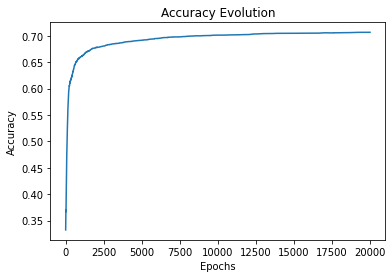

In [ ]:
plt.title ("Accuracy Evolution")
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy")
plt.plot (range(n_epochs),accuracy_train_history)

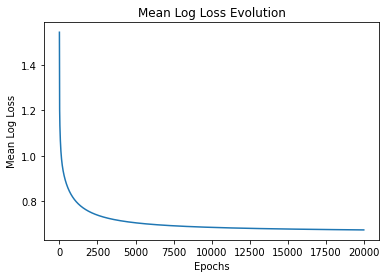

In [ ]:
plt.title ("Mean Log Loss Evolution")
plt.xlabel ("Epochs")
plt.ylabel ("Mean Log Loss")
plt.plot (range(n_epochs),error_train_history)

In [ ]:
final_accuracy_train = accuracy (predict(x_train),t_train)
final_accuracy_dev = accuracy (predict(x_dev),t_dev)
final_train_mean_log_loss = mean_log_loss(net(x_train),t_train)
final_dev_mean_log_loss = mean_log_loss(net(x_dev),t_dev)

print ("Final Accuracy in training: "+str(final_accuracy_train.numpy()))
print ("Final Accuracy for the development test set: "+str(final_accuracy_dev.numpy()))
print ("Final training mean-log-loss in training: "+str(final_train_mean_log_loss.numpy()))
print ("Final mean-log-loss for the development test set: "+str(final_dev_mean_log_loss.numpy()))

Final Accuracy in training: 0.7064619
Final Accuracy for the development test set: 0.7097406
Final training mean-log-loss in training: 0.6726655
Final mean-log-loss for the development test set: 0.64666694


In [ ]:
predictions = predict(x_dev)

In [ ]:
predictions[:20].numpy()

array([[3.06553453e-01, 5.61864614e-01, 1.31582022e-01],
       [8.37665331e-03, 1.19029447e-01, 8.72593880e-01],
       [8.37536573e-01, 1.59458503e-01, 3.00498377e-03],
       [2.06759498e-02, 4.02891248e-01, 5.76432765e-01],
       [7.93223560e-01, 1.91933393e-01, 1.48430672e-02],
       [5.55233434e-02, 5.34760475e-01, 4.09716219e-01],
       [1.60081256e-02, 4.00499731e-01, 5.83492160e-01],
       [1.24160119e-03, 1.06519096e-01, 8.92239273e-01],
       [3.85939600e-08, 5.13496401e-04, 9.99486446e-01],
       [5.37318945e-01, 4.04047519e-01, 5.86335510e-02],
       [1.80490613e-01, 6.50347948e-01, 1.69161484e-01],
       [4.31243777e-01, 4.65603054e-01, 1.03153192e-01],
       [4.80482191e-01, 4.34383035e-01, 8.51347521e-02],
       [3.52361888e-01, 4.55312371e-01, 1.92325771e-01],
       [9.94038701e-01, 5.95187023e-03, 9.52915980e-06],
       [2.91801821e-02, 1.93311006e-01, 7.77508795e-01],
       [8.24697196e-01, 1.63431868e-01, 1.18709402e-02],
       [1.14634482e-03, 1.38519

In [ ]:
rounded_predictions=np.round(predictions)
indices = np.argmax(predictions,1)
for row, index in zip(rounded_predictions, indices): row[index]=1
rounded_predictions[:20]

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
t_dev[:20].numpy()

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
dev_predictions = correct_predictions(predict(x_dev),t_dev).numpy()
dev_predictions[:20]

array([False,  True,  True, False, False,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True])

In [ ]:
from collections import Counter
Counter(dev_predictions)

Counter({False: 593, True: 1450})

**The accuracy** is 70% for the training set and 71% for the development (unseen data) dataset. Dev samples have been employed to adjust the learning rate to $\alpha = 0.1$ and the number of epochs to 20,000. Note that training has taken about **two minutes** for a simple model without hidden layers. There are 9 inputs x 3 outputs = 27 weights (the kernel size) + 3 bias = **only 30 parameters to adjust**.  